In [7]:
import pickle

#google colabのとき↓
#/content/drive/MyDrive/dataset/
#研究室PCのとき↓
#/Users/Ma-Lab-PC3/SatoMaho/

def read_pickle(file_name):
    with open("/Users/Ma-Lab-PC3/SatoMaho/" + file_name + ".pickle", "rb") as f:
        dic = pickle.load(f)
    return dic["x"], dic["y"]

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
#from sklearn.model_selection import train_test_split
from torchvision import transforms

In [9]:
import sys 
sys.path.append('c:/users/admin/appdata/roaming/python/python39/site-packages') 
import torch

## 位置符号化

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, l):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(l, d_model)
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        pe = pe.to(device)
        for pos in range(l):
            for i in range(0, d_model, 2):
                pe[pos, i] = np.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i + 1] = np.cos(pos / 10000 ** ((2 * (i + 1) / d_model)))
        
        self.pe = pe.unsqueeze(0)
        self.pe.requires_grad = False

    def forward(self, x):
        ret = np.sqrt(self.d_model) * x + self.pe
        return ret

## Transformerモデル

In [217]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(1, 64, 65)
        self.conv2 = nn.Conv1d(64, 128, 33)
        self.conv3 = nn.Conv1d(128, 256, 17)
        #self.conv4 = nn.Conv1d(256, 512, 7)

        torch.nn.init.kaiming_normal_(self.conv1.weight)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        #torch.nn.init.kaiming_normal_(self.conv4.weight)

        self.dropout1 = nn.Dropout(0.1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        #self.bn4 = nn.BatchNorm1d(512)

        self.cls = nn.Parameter(torch.zeros(1, 1, 256))

        self.positionembedding = PositionalEncoding(256, 1169) #529
        #self.positionEmbedding = nn.Parameter(torch.zeros(1, 529, 256))

        encoderLayer = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dropout = 0.2, batch_first = True)
        self.encoder = nn.TransformerEncoder(encoderLayer, num_layers = 4)

        self.linear = nn.Linear(256, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.conv3(x)
        #x = self.dropout1(x)
        x = self.relu(x)
        x = self.bn3(x)
        #x = self.conv4(x)
        #x = self.relu(x)
        #x = self.bn4(x)

        # x 原始形状：(batch_size, feature_dim, seq_len)
        # 交换第2维（feature_dim）和第3维（seq_len）
        # Transformer的输入格式要求 (batch_size, seq_len, feature_dim)，即时间步在第2维，而特征维度在第3维。
        # Conv1d 输出的默认格式是 (batch_size, feature_dim, seq_len)，因此需要转置。
        x = torch.transpose(x, 2, 1)

        
        clsToken = self.cls.repeat_interleave(x.shape[0], dim = 0)
        x = torch.cat((clsToken, x), dim = 1)
        x = self.positionembedding(x)
        x = self.encoder(x)
        x = self.linear(x[:, 0, :])
        return x

## CNNモデル

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        self.conv1 = nn.Conv1d(1, 64, 17)
        self.conv2 = nn.Conv1d(64, 128, 17)
        self.conv3 = nn.Conv1d(128, 256, 17)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)

        self.fc1 = nn.Linear(151552, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.conv1(x)
        x = self.relu(x)
        #x = self.pool(x)
        #x = self.bn2(self.conv2(x))
        x = self.conv2(x)
        x = self.relu(x)
        #x = self.pool(x)
        #x = self.bn3(self.conv3(x))
        x = self.conv3(x)
        x = self.relu(x)
        #x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [187]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label, transform = None):
        self.transform = transform
        self.data = data
        self.data_num = len(data)
        self.label = label

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        if self.transform:
            out_data = self.transform(self.data)[0][idx]
            out_label = self.label[idx]
        else:
            out_data = self.data[idx]
            out_label = self.label[idx]
        #out_data = out_data.unsqueeze(0)  # 形状を (1, channels, seq_len) に変更
        return out_data, out_label

## データ

In [218]:
x, y = read_pickle("10sproceedsubjectsP40")
print(x.shape)
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(x, y, transform) #dataset[?][0]生体データ、dataset[?][1]ラベル
r = 0.8
Iter = iter(dataset)
xdata, ydata = next(Iter) #教師データ、ラベルデータ

print(xdata.shape)  # ここで確認
print(ydata.shape)  # ラベルの形状も確認
#print(dataset[0][0])
train_size = int(len(dataset) * r)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True, drop_last = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = True, drop_last = True)

(45211, 1280)
torch.Size([1280])
()


## google colabのときのみ

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
from torch.optim.lr_scheduler import StepLR

In [27]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [29]:
import sys
print(sys.executable)

c:\Users\Ma-Lab-PC3\AppData\Local\Programs\Python\Python39\python.exe


In [28]:
from ignite.handlers import EarlyStopping

c:\Users\Ma-Lab-PC3\SatoMaho\myenv\lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## 早期停止

In [30]:
class EarlyStopping:
    """earlystoppingクラス"""
    
    def __init__(self, patience, verbose=False, path='BatchNormalization_model.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""
        
        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = path             #ベストモデル格納path
        
    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する


## 学習

In [189]:
def train(dataloader, epoch, model, criterion, optimizer):
  size = len(dataloader.dataset)
  for e in range(epoch):
      train_loss_sum = 0
      train_acc_sum = 0
      val_loss_sum = 0
      val_acc_sum = 0
      model.train()
      for batch, (x, y) in enumerate(dataloader):
        x = x.unsqueeze(1)
        x, y = x.to(device, dtype = torch.float32), y.to(device, dtype = torch.long)

        optimizer.zero_grad()
        pred = model(x)
        #print(pred)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
        pred = pred.argmax(1)
        train_acc_sum += pred.eq(y.view_as(pred)).sum().item()

      model.eval()
      with torch.no_grad():
        for x, y in test_dataloader:
          x = x.unsqueeze(1)
          x, y = x.to(device, dtype = torch.float32), y.to(device, dtype = torch.long)
          pred = model(x)
          val_loss_sum += loss_fn(pred, y).item()
          pred = pred.argmax(1)
          val_acc_sum += pred.eq(y.view_as(pred)).sum().item()

      train_loss = train_loss_sum / len(dataloader)
      train_acc = train_acc_sum / train_size
      val_loss = val_loss_sum / len(dataloader)
      val_acc = val_acc_sum / test_size
      scheduler.step(val_loss)
      early_stopping(val_loss, model)
      if early_stopping.early_stop:
        print("Early Stop!")
        break
      train_loss_list.append(train_loss)
      train_acc_list.append(train_acc)
      val_loss_list.append(val_loss)
      val_acc_list.append(val_acc)
      print(f"{e + 1} / {epoch} | Train Loss : {train_loss}, Acc : {100 * train_acc}, Val Loss : {val_loss}, Acc : {100 * val_acc}")

## テスト

In [190]:
def test(dataloader, model, loss_fn):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.unsqueeze(1)
            x, y = x.to(device, dtype = torch.float32), y.to(device, dtype = torch.long)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            pred = pred.argmax(1)
            correct += pred.eq(y.view_as(pred)).sum().item()
    print(f"Loss : {test_loss / len(dataloader)}, Accuracy : {100 * correct / test_size}%")

In [101]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


## 実行

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = Transformer()
net = net.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = 0.00001)
#scheduler = StepLR(optimizer, step_size = 45, gamma = 0.65)
scheduler = ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience = 10)
early_stopping = EarlyStopping(patience = 30)

In [220]:
epochs = 500
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
train(train_dataloader, epochs, net, loss_fn, optimizer)
net.load_state_dict(torch.load("BatchNormalization_model.pth"))
test(test_dataloader, net, loss_fn)
print("Done!")

1 / 500 | Train Loss : 0.641484314134541, Acc : 64.19210351692104, Val Loss : 0.15918121528761284, Acc : 69.76667035275904
2 / 500 | Train Loss : 0.6076630951168855, Acc : 68.18734793187348, Val Loss : 0.16698871841013524, Acc : 61.35132146411589
3 / 500 | Train Loss : 0.5896257456388754, Acc : 69.61125857111259, Val Loss : 0.14784680174330356, Acc : 67.09056728961627
4 / 500 | Train Loss : 0.564584745416775, Acc : 71.36695421366954, Val Loss : 0.14716734518922225, Acc : 71.32588742673892
5 / 500 | Train Loss : 0.5441428104918586, Acc : 72.94016810440168, Val Loss : 0.15475721174908327, Acc : 67.88676324228685
6 / 500 | Train Loss : 0.5575756888043113, Acc : 72.24618447246185, Val Loss : 0.13277547149528604, Acc : 73.61495079066681
7 / 500 | Train Loss : 0.5350708372044705, Acc : 73.44061048440611, Val Loss : 0.12329505435880163, Acc : 75.92613070883556
8 / 500 | Train Loss : 0.5224157827651902, Acc : 74.07376686573767, Val Loss : 0.1305226512390068, Acc : 74.62125400862546
9 / 500 | T

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


net.load_state_dict(torch.load("BatchNormalization_model.pth"))
test(test_dataloader, net, loss_fn)
print("Done!")

## 損失グラフ

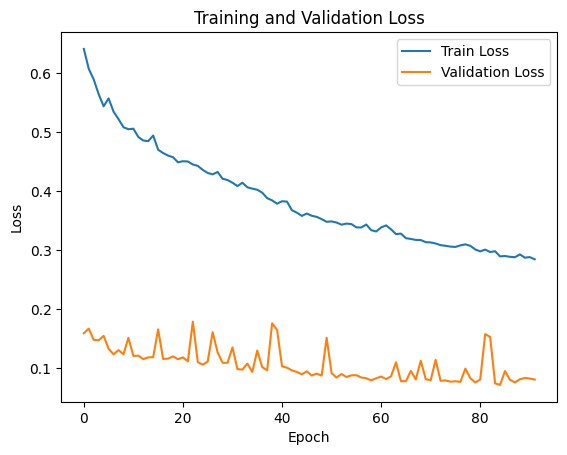

In [221]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 精度グラフ

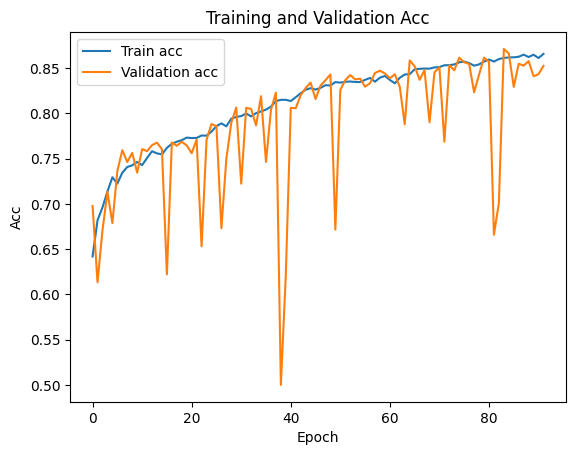

In [222]:
plt.plot(train_acc_list, label='Train acc')
plt.plot(val_acc_list, label='Validation acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()